In [1]:
'''
Author: Mauricio Gonzalez
Institute: Universidad Tecnica Federico Santa Maria
Documentation: MC_code_documentation.txt
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def kroupa_imf(number_of_stars):

    # Define the power-law indices for the Kroupa IMF
    alpha1 = 0.3
    alpha2 = 1.3
    alpha3 = 2.3

    # Define the mass ranges for the piecewise function
    m1 = (0.01, 0.08)
    m2 = (0.08, 0.50)
    m3 = (0.50, 100.00) 

    # Calculate the normalized weights for each segment
    w1 = ((m1[1]**(1.0 - alpha1) - m1[0]**(1.0 - alpha1)) / (1.0 - alpha1))
    w2 = ((m2[1]**(1.0 - alpha2) - m2[0]**(1.0 - alpha2)) / (1.0 - alpha2))
    w3 = ((m3[1]**(1.0 - alpha3) - m3[0]**(1.0 - alpha3)) / (1.0 - alpha3))
    total_weight = w1 + w2 + w3

    # Calculate the probability for each segment
    p1 = w1 / total_weight
    p2 = w2 / total_weight
    p3 = w3 / total_weight

    # Decide how many stars belong to each mass segment
    stars1 = np.random.binomial(number_of_stars, p1)
    stars2 = np.random.binomial(number_of_stars - stars1, p2 / (p2 + p3))
    stars3 = number_of_stars - stars1 - stars2

    # Function to generate masses according to a power-law distribution
    def generate_masses(n, alpha, mass_range):
        min_mass, max_mass = mass_range
        # Generate random numbers with a power-law distribution
        return ((max_mass**(1.0 - alpha) - min_mass**(1.0 - alpha)) * np.random.random(n) + min_mass**(1.0 - alpha))**(1.0 / (1.0 - alpha))

    # Generate the masses for each segment
    masses1 = generate_masses(stars1, alpha1, m1)
    masses2 = generate_masses(stars2, alpha2, m2)
    masses3 = generate_masses(stars3, alpha3, m3)

    # Combine the masses into one array and return it
    return np.concatenate([masses1, masses2, masses3])

In [3]:
def assign_birth_times(number_of_stars,max_age):

    # The Milky Way is approximately 10 Gyr old.
    # We assume a constant star formation rate over this time.
    # Generate birth times with a uniform distribution between 0 and max_age Gyr.
    return np.random.uniform(0, max_age, number_of_stars)

In [4]:
def main_sequence_lifetime(mass,birth_time,max_age):

    # Use the mass-luminosity relation for stars less than 55 Msun
    # lifetime ~ 1 / mass^2.5 (since luminosity ~ mass^3.5)
    t_ms = 10 / (mass**2.5) # Lifetimes are in Gyr for stars of 1 Msun
    
    # Determine if stars have ended their main sequence life
    # We calcualte the difference between main sequence lifetime - birth time 
    # If the difference is greater than 0, the star has ended its main sequence life.
    
    if t_ms - birth_time > 0:
        return t_ms, True
    else:
        return t_ms, False   

In [5]:
def make_star_dataframe(num_of_star, max_age):

    # Generate stellar masses using the Kroupa IMF
    stellar_masses = kroupa_imf(num_of_star)
    
    # Assign birth times (ages) with a uniform distribution between 0 and max_age (Gyr)
    ages = assign_birth_times(num_of_star,max_age)
    
    # Lets shuffle stellar_masses and ages
    np.random.shuffle(stellar_masses)
    np.random.shuffle(ages)
    
    # Calculate main sequence lifetimes based on mass
    stars_main_sequence_lifetimes = []
    ms_states = []
    for n in range(len(ages)):
        msl,mss =main_sequence_lifetime(stellar_masses[n],ages[n],max_age)
        stars_main_sequence_lifetimes.append(msl)
        ms_states.append(mss)
        
    stars_main_sequence_lifetimes=np.array(stars_main_sequence_lifetimes)
    ms_states=np.array(ms_states)
    
    # Determine ms state and if a star is a stellar remnant
    stellar_remnants = ~ms_states

    # Create DataFrame
    stars_df = pd.DataFrame({
        'initial_mass': stellar_masses,
        'age': ages,
        'main_sequence_lifetime [Gyr]': stars_main_sequence_lifetimes,
        'ms_state': ms_states,
        'stellar_remnant': stellar_remnants
    })

    return stars_df

In [6]:
##############################################################
###################### IMPUT VARIABLES #######################
##############################################################

numbers_of_stars = np.array([100, 1000, 10000, 100000, 1000000,100000000])
#numbers_of_stars = np.array([100000000000])
max_star_age = 10  # Max age of stars in Gyears. The age of the Milky Way (10 Gyr)

##############################################################
##############################################################
##############################################################

In [7]:
# Make dictonary for storing all data frames
stars_df_dis = {}
for i in numbers_of_stars: # For all simulations
    stars_df_dis[str(i)] = make_star_dataframe(i, max_star_age)

In [8]:
#(stars_df_dis['1000000']).head()  # Display the first 5 rows (stars) *Example

In [9]:
def determine_stellar_remnant(initial_mass):

    def white_dwarf_ifmr(initial_mass):
        # Equation for White Dwarf from Kalirai et al. (2008)
        return 0.109 * initial_mass + 0.394

    def neutron_star_ifmr(initial_mass):
      # Equation for Branch I,II,III and IV from Raithel et al. (2018)
        if 9 <= initial_mass <= 13:
            return 2.24 + 0.508*(initial_mass - 14.75) + 0.125*(initial_mass - 14.75)**2 + 0.0110*(initial_mass - 14.75)**3
        
        elif 9 < initial_mass < 13:
            return 0.123 + 0.112 * initial_mass
        
        elif 15 <= initial_mass <= 17.8:
            return 0.996 + 0.0384 * initial_mass
        
        elif 17.8 < initial_mass < 18.5:
            return -0.020 + 0.1 * initial_mass
        
        else:
            return None  # This could be an indication that the star is not a neutron star

    def black_hole_ifmr(initial_mass, fej=0.9):
        # Branch II: Implosion of the CO-core (45 M☉ ≤ initial_mass ≤ 120 M☉)
        if 45 <= initial_mass <= 120:
            mbh_core = 5.697 + 7.8598 * (10**8) * initial_mass**(-4.858)
            return mbh_core

        # Branch I: Implosion of He-core or entire star (15 M☉ ≤ initial_mass ≤ 40 M☉)
        elif 15 <= initial_mass <= 40:
            # Calculation for mbh_core (fej = 1)
            mbh_core = -2.049 + 0.414 * initial_mass
            
            # Calculation for mbh_all (fej = 0)
            mbh_all = 15.52 - 0.3294 * (initial_mass - 25.97) \
                    - 0.02121 * (initial_mass - 25.97)**2 \
                    + 0.003120 * (initial_mass - 25.97)**3
            
            # Using the ejection fraction to interpolate between mbh_core and mbh_all
            mbh = fej * mbh_core + (1 - fej) * mbh_all
            return mbh

        else:
            return None  # This could be an indication that the star is not a black hole
    
    # Apply the white dwarf IFMR if the initial mass is in the range for white dwarfs.
    if initial_mass <= 8:  # Assuming stars up to 8 solar masses become white dwarfs.
        final_mass = white_dwarf_ifmr(initial_mass)
        remnant_type = 'White Dwarf'
    
    # Apply the neutron star IFMR if the initial mass is in the range for neutron stars.
    elif 8 < initial_mass <= 20:  # Assuming stars between 8 and 20 solar masses become neutron stars.
        final_mass = neutron_star_ifmr(initial_mass)
        remnant_type = 'Neutron Star' if final_mass is not None else 'Unknown'
    
    # Apply the black hole IFMR if the initial mass is in the range for black holes.
    elif initial_mass > 20:  # Assuming stars over 20 solar masses become black holes.
        final_mass = black_hole_ifmr(initial_mass)
        remnant_type = 'Black Hole' if final_mass is not None else 'Unknown'
    
    else:
        final_mass = None
        remnant_type = 'Unknown'
    
    return remnant_type, final_mass

# Define a function to apply to the DataFrame
def add_stellar_remnant_info(row):
    rt, fm = determine_stellar_remnant(row['initial_mass'])
    if row['stellar_remnant']:
        return rt,fm
    else:
        return 'Main Sequence', row['initial_mass'] # or some default values indicating no remnant

In [10]:
# Apply the function across the DataFrame rows
# The result will be a Series of tuples

for i in numbers_of_stars: 

    remnant_info = (stars_df_dis[str(i)]).apply(add_stellar_remnant_info, axis=1)

    # Split the Series of tuples into two separate Series and add them as new columns to the DataFrame
    (stars_df_dis[str(i)])['remnant_type'], (stars_df_dis[str(i)])['final_mass'] = zip(*remnant_info)


/Users/mauriciogonzalez/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


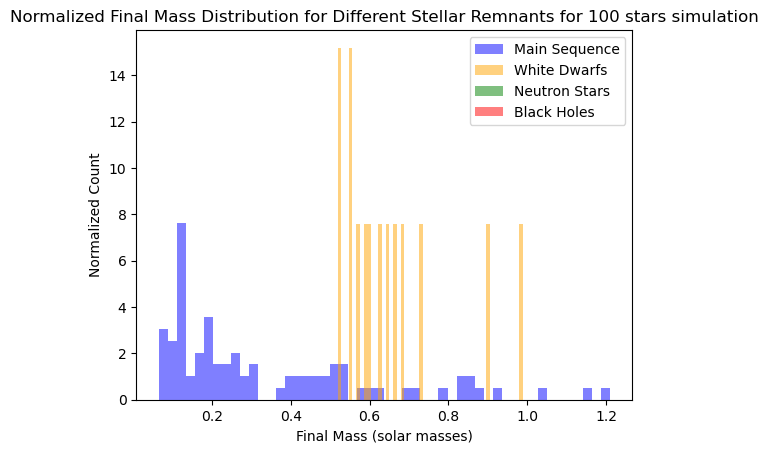

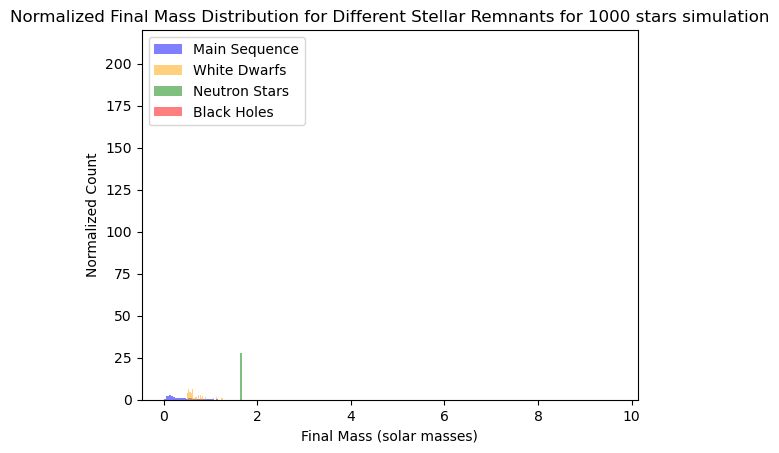

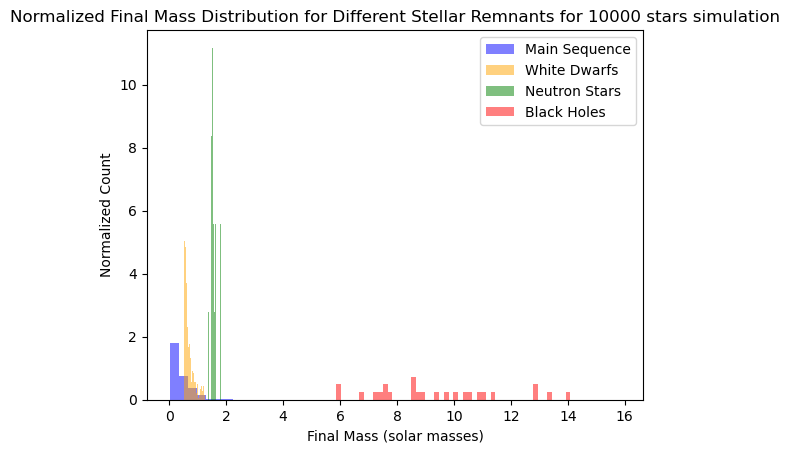

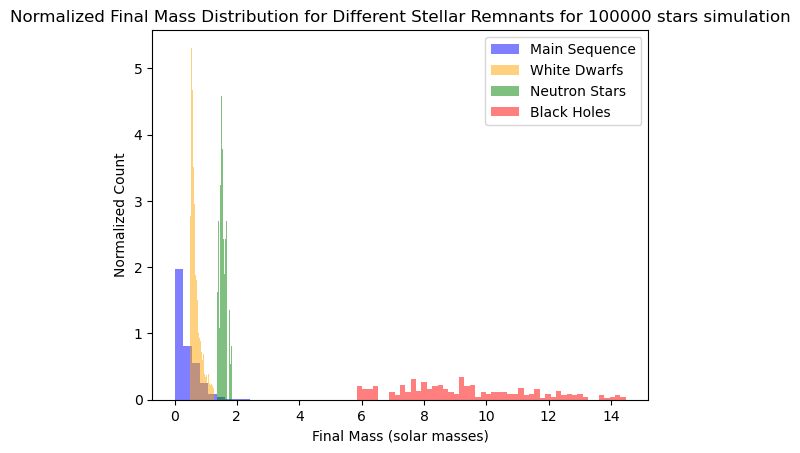

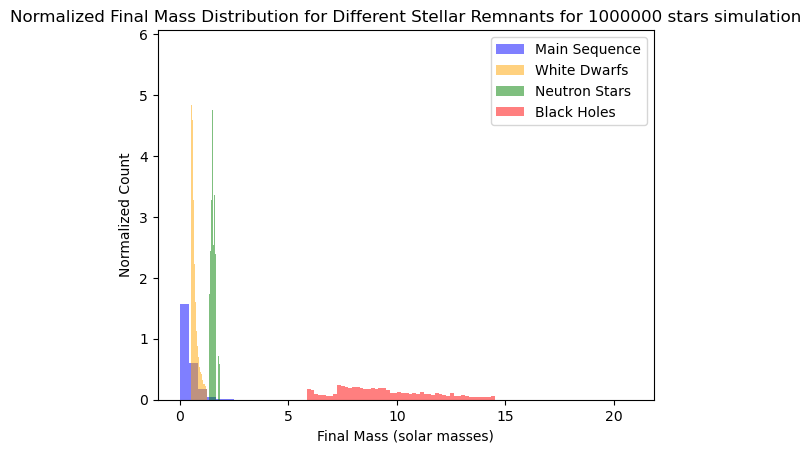

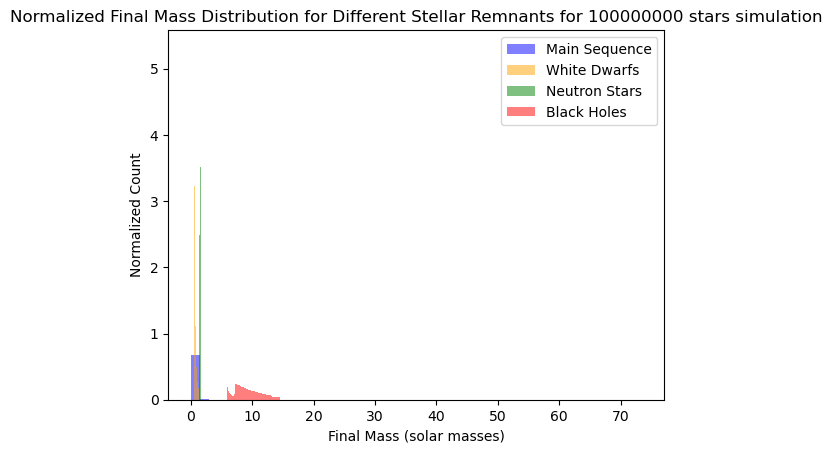

In [11]:
# Normalized Final Mass Distribution for Different Stellar Remnants
for i in numbers_of_stars: # For all simulations
    
    # Filter the DataFrame by remnant type
    main_sequence = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'Main Sequence']
    white_dwarfs = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'White Dwarf']
    neutron_stars = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'Neutron Star']
    black_holes = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'Black Hole']

    # Plot the histograms
    plt.hist(main_sequence['final_mass'], bins=50, color='blue', alpha=0.5, density=True, label='Main Sequence')
    plt.hist(white_dwarfs['final_mass'], bins=50, color='orange', alpha=0.5, density=True, label='White Dwarfs')
    plt.hist(neutron_stars['final_mass'], bins=50, color='green', alpha=0.5, density=True, label='Neutron Stars')
    plt.hist(black_holes['final_mass'], bins=50, color='red', alpha=0.5, density=True, label='Black Holes')

    # Add labels and title
    plt.xlabel('Final Mass (solar masses)')
    plt.ylabel('Normalized Count')
    plt.title('Normalized Final Mass Distribution for Different Stellar Remnants for '+str(i)+' stars simulation')
    plt.legend()

    # Show the plot
    plt.show()

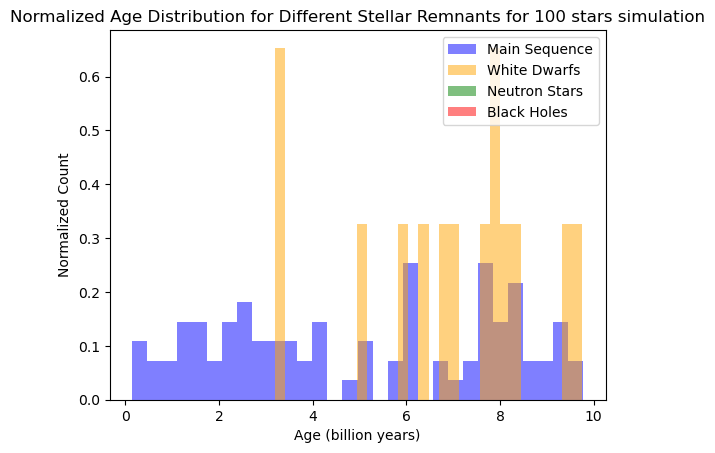

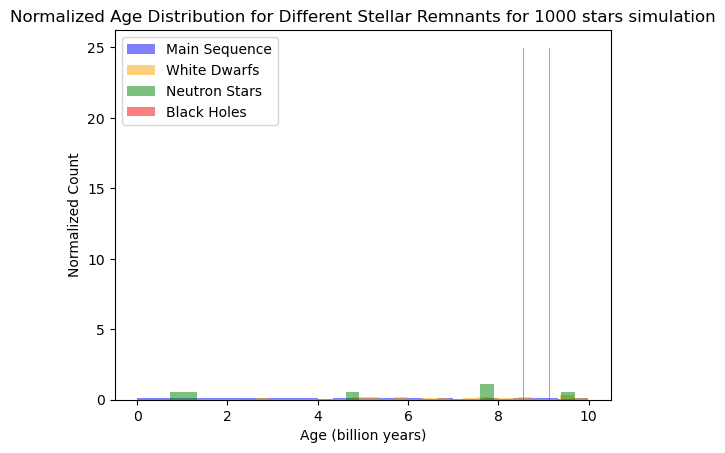

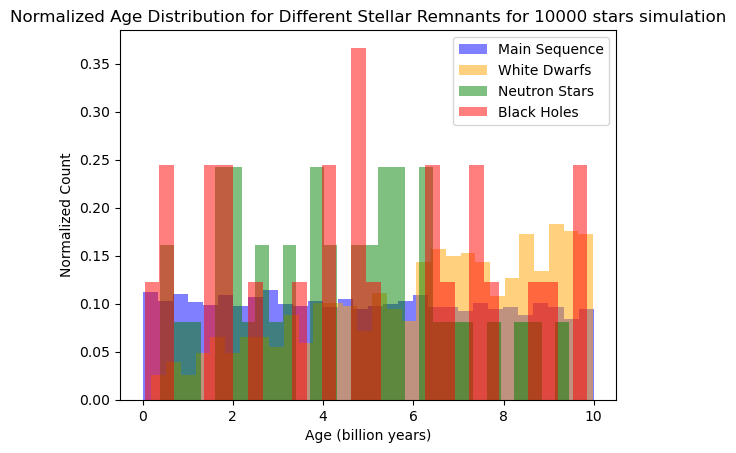

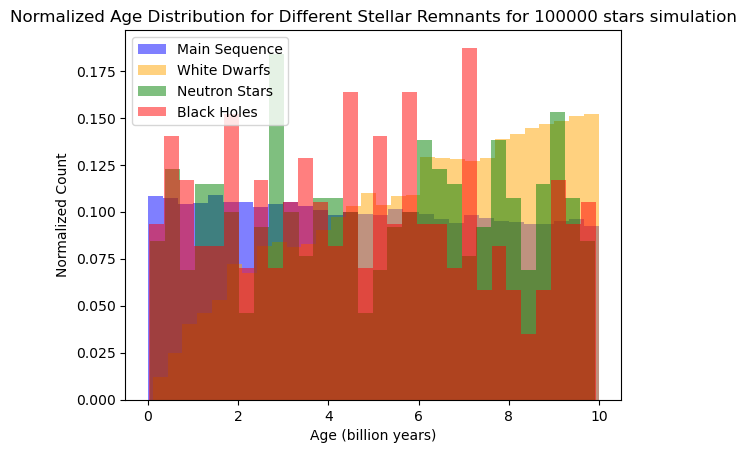

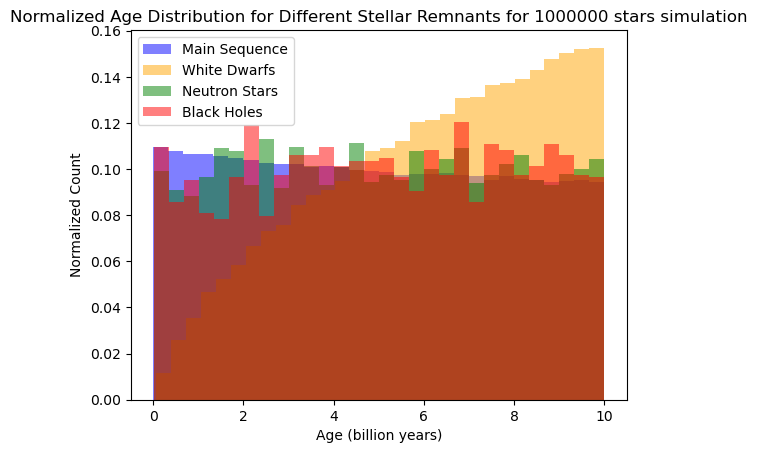

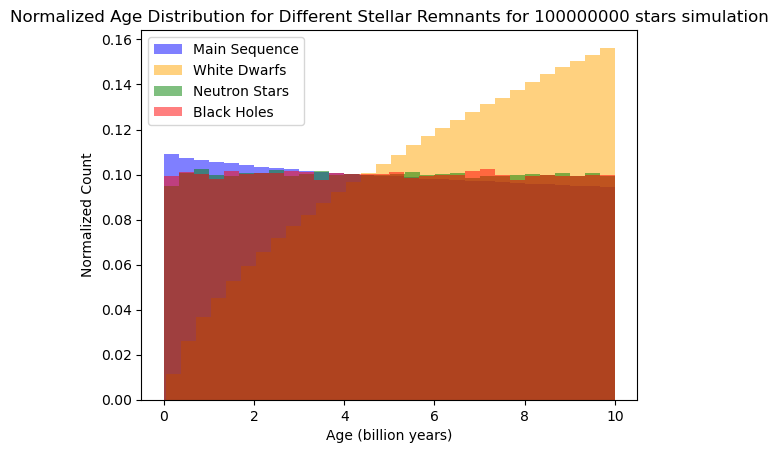

In [12]:
# Normalized Age Distribution for Different Stellar Remnants
for i in numbers_of_stars: # For all simulations  
    
    # Filter the DataFrame by remnant type
    main_sequence_ages = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'Main Sequence']['age']
    white_dwarfs_ages = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'White Dwarf']['age']
    neutron_stars_ages = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'Neutron Star']['age']
    black_holes_ages = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'Black Hole']['age']

    # Plot the histograms
    plt.hist(main_sequence_ages, bins=30, color='blue', alpha=0.5, density=True, label='Main Sequence')
    plt.hist(white_dwarfs_ages, bins=30, color='orange', alpha=0.5, density=True, label='White Dwarfs')
    plt.hist(neutron_stars_ages, bins=30, color='green', alpha=0.5, density=True, label='Neutron Stars')
    plt.hist(black_holes_ages, bins=30, color='red', alpha=0.5, density=True, label='Black Holes')

    # Add labels and title
    plt.xlabel('Age (billion years)')
    plt.ylabel('Normalized Count')
    plt.title('Normalized Age Distribution for Different Stellar Remnants for '+str(i)+' stars simulation')
    plt.legend()

    # Show the plot
    plt.show()



In [13]:
# Create dictionary for fraction data frame 
fractions_df_dic = {}
for i in numbers_of_stars:

    # Filter the DataFrame by remnant type
    main_sequence = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'Main Sequence']
    white_dwarfs = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'White Dwarf']
    neutron_stars = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'Neutron Star']
    black_holes = (stars_df_dis[str(i)])[(stars_df_dis[str(i)])['remnant_type'] == 'Black Hole']
    
    # Calculate the fraction for each type of stellar body
    total_stars = i
    fractions = {
        'Main Sequence': len(main_sequence) / total_stars,
        'White Dwarf': len(white_dwarfs) / total_stars,
        'Neutron Star': len(neutron_stars) / total_stars,
        'Black Hole': len(black_holes) / total_stars
    }

    # Create a mock fraction based on known Milky Way census for comparison
    # These are not real values, just placeholders for demonstration
    milky_way_census = {
        'Main Sequence': 0.9,  # Hypothetical fraction of Main Sequence stars in the Milky Way
        'White Dwarf': 0.097,    # Hypothetical fraction of White Dwarfs in the Milky Way
        'Neutron Star': 0.00273,  # Hypothetical fraction of Neutron Stars in the Milky Way
        'Black Hole': 0.00027     # Hypothetical fraction of Black Holes in the Milky Way
    }

    # Compare the fractions to see if they are consistent with the Milky Way census
    consistency = {remnant: abs(fractions[remnant] - milky_way_census[remnant]) <= 0.01 for remnant in fractions}

    # Convert the data to a pandas DataFrame for table representation
    fractions_df = pd.DataFrame({
        'Stellar Body': ['Main Sequence', 'White Dwarf', 'Neutron Star', 'Black Hole'],
        'Simulated Fraction': [fractions['Main Sequence'], fractions['White Dwarf'], fractions['Neutron Star'], fractions['Black Hole']],
        'Milky Way Census': [milky_way_census['Main Sequence'], milky_way_census['White Dwarf'], milky_way_census['Neutron Star'], milky_way_census['Black Hole']],
        'Consistent': [consistency['Main Sequence'], consistency['White Dwarf'], consistency['Neutron Star'], consistency['Black Hole']]
    })

    fractions_df.set_index('Stellar Body', inplace=True)
    fractions_df_dic[str(i)] = fractions_df

In [14]:
fractions_df_dic['100']

,Simulated Fraction,Milky Way Census,Consistent
Stellar Body,,,
Main Sequence,0.86,0.90000,False
White Dwarf,0.14,0.09700,False
Neutron Star,0.00,0.00273,True
Black Hole,0.00,0.00027,True


In [15]:
fractions_df_dic['1000']

,Simulated Fraction,Milky Way Census,Consistent
Stellar Body,,,
Main Sequence,0.905,0.90000,True
White Dwarf,0.086,0.09700,False
Neutron Star,0.006,0.00273,True
Black Hole,0.002,0.00027,True


In [16]:
fractions_df_dic['10000']

,Simulated Fraction,Milky Way Census,Consistent
Stellar Body,,,
Main Sequence,0.8972,0.90000,True
White Dwarf,0.0940,0.09700,True
Neutron Star,0.0041,0.00273,True
Black Hole,0.0025,0.00027,True


In [17]:
fractions_df_dic['100000']

,Simulated Fraction,Milky Way Census,Consistent
Stellar Body,,,
Main Sequence,0.90049,0.90000,True
White Dwarf,0.09006,0.09700,True
Neutron Star,0.00397,0.00273,True
Black Hole,0.00259,0.00027,True


In [18]:
fractions_df_dic['1000000']

,Simulated Fraction,Milky Way Census,Consistent
Stellar Body,,,
Main Sequence,0.901027,0.90000,True
White Dwarf,0.089166,0.09700,True
Neutron Star,0.004354,0.00273,True
Black Hole,0.002524,0.00027,True
